# import libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.__version__

'1.1.0'

In [3]:
import sys

In [4]:
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# random seed settings

In [6]:
import random

In [7]:
random.seed(1)

torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

# Data Load

In [8]:
from lib.mnist import *

In [9]:
mymnist = MyMNIST()

In [10]:
import matplotlib.pyplot as plt

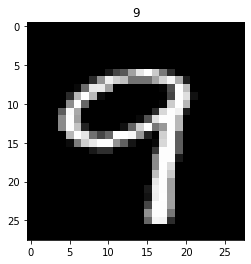

In [11]:
for X, Y in mymnist.train_data_loader:
    plt.imshow(X[0].reshape(28, 28), cmap = 'gray')
    plt.title('{}'.format(Y[0]))
    plt.show()
    break

# Variational Autoencoder(VAE)

* objective: Maximize ELBO(Evidence Lower Bound)
    * `Minimize Reconstruction Error & KL Divergence`
    * Final goal: Marginal log-likelihood log p(x)
* The original paper of VAE: [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).

In [12]:
num_z = 2 # z from sampling. latent variable

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # for encoder
        self.enc_layer1 = nn.Linear(in_features = 28*28, out_features = 512)
        self.enc_layer2 = nn.Linear(in_features = 512, out_features = 256)
        
        # encoder z_mean & z_log_sigma_sq
        self.z_mean_layer = nn.Linear(256, num_z)
        self.z_log_sigma_sq_layer  = nn.Linear(256, num_z)
    
    def reparam(self, z_mean, z_log_sigma_sq):
        """Methods required for computing calculations in VAE"""
        
        eps = torch.randn(num_z)
        eps = eps.to(device)
        
        z = z_mean + torch.sqrt(torch.exp(z_log_sigma_sq)) * eps
        
        return eps, z
                
    def forward(self, x):
        x = F.relu(self.enc_layer1(x))
        x = F.relu(self.enc_layer2(x))
        
        # sampling z 
        z_mean = self.z_mean_layer(x)
        z_log_sigma_sq  = self.z_log_sigma_sq_layer(x)
    
        
        eps, z = self.reparam(z_mean, z_log_sigma_sq)
        return z_mean, z_log_sigma_sq, eps, z

In [14]:
encoder = Encoder().to(device)

In [15]:
encoder

Encoder(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=256, bias=True)
  (z_mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (z_log_sigma_sq_layer): Linear(in_features=256, out_features=2, bias=True)
)

In [16]:
X = X.to(device)

In [17]:
encoder(X[0].view(1, 28*28))

(tensor([[0.0599, 0.0284]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.0254, -0.0824]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([-1.3132,  0.2915], device='cuda:0'),
 tensor([[-1.2701,  0.3081]], device='cuda:0', grad_fn=<AddBackward0>))

In [18]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
 
        # for decoder
        self.dec_layer1 = nn.Linear(in_features = num_z, out_features = 256)
        self.dec_layer2 = nn.Linear(in_features = 256, out_features = 512)
        
        # for reconstruction
        self.recons_layer = nn.Linear(512, 28*28)
        
    def forward(self, x):
        x = F.relu(self.dec_layer1(x))
        x = F.relu(self.dec_layer2(x))
        
        x = self.recons_layer(x)
        x = torch.sigmoid(x)
    
        return x

In [19]:
decoder = Decoder().to(device)

In [20]:
decoder

Decoder(
  (dec_layer1): Linear(in_features=2, out_features=256, bias=True)
  (dec_layer2): Linear(in_features=256, out_features=512, bias=True)
  (recons_layer): Linear(in_features=512, out_features=784, bias=True)
)

In [21]:
decoder(torch.randn(1,num_z).to(device)).shape

torch.Size([1, 784])

train mode

In [22]:
encoder.train()

Encoder(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=256, bias=True)
  (z_mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (z_log_sigma_sq_layer): Linear(in_features=256, out_features=2, bias=True)
)

In [23]:
decoder.train()

Decoder(
  (dec_layer1): Linear(in_features=2, out_features=256, bias=True)
  (dec_layer2): Linear(in_features=256, out_features=512, bias=True)
  (recons_layer): Linear(in_features=512, out_features=784, bias=True)
)

In [24]:
params = list(encoder.parameters())+ list(decoder.parameters())

In [25]:
learning_rate = 1e-3
epochs = 50

In [26]:
optimizer = optim.Adam(params, lr=learning_rate)

In [27]:
recons_loss_function = nn.BCELoss(reduction ='sum')

In [28]:
X.shape

torch.Size([128, 1, 28, 28])

# Training

In [29]:
for i in range(epochs):
    for X, Y in mymnist.train_data_loader:
        avg_loss = 0
        X = X.view([-1, 28*28]).to(device)

        z_mean, z_log_sigma_sq, eps, z = encoder(X)
        X_hat = decoder(z)

        recons_loss = -recons_loss_function(X_hat, X) # reconstruction error
        # epsilon = 1e-10
        # recons_loss = torch.sum(X * torch.log(epsilon + X_hat) + (1-X) * torch.log(epsilon + 1 - X_hat))
    
        # KL-Divergence
        KLD = 0.5 * torch.sum(z_mean**2 + torch.exp(z_log_sigma_sq) 
                              -z_log_sigma_sq -1)

        ELBO = torch.mean(-recons_loss + KLD)

        optimizer.zero_grad()
        ELBO.backward()
        optimizer.step()
        
        avg_loss += ELBO / len(mymnist.train_data_loader)
    
    print('Epoch: {}, avg loss: {}'.format(i+1, avg_loss))

Epoch: 1, avg loss: 47.2318115234375
Epoch: 2, avg loss: 44.66691207885742
Epoch: 3, avg loss: 43.663082122802734
Epoch: 4, avg loss: 42.62567138671875
Epoch: 5, avg loss: 44.579444885253906
Epoch: 6, avg loss: 40.05260467529297
Epoch: 7, avg loss: 42.400577545166016
Epoch: 8, avg loss: 39.35895919799805
Epoch: 9, avg loss: 41.52810287475586
Epoch: 10, avg loss: 40.94784927368164
Epoch: 11, avg loss: 39.12813949584961
Epoch: 12, avg loss: 41.689178466796875
Epoch: 13, avg loss: 41.97501754760742
Epoch: 14, avg loss: 39.91856002807617
Epoch: 15, avg loss: 39.60300827026367
Epoch: 16, avg loss: 39.05042266845703
Epoch: 17, avg loss: 40.757728576660156
Epoch: 18, avg loss: 39.510677337646484
Epoch: 19, avg loss: 36.88251876831055
Epoch: 20, avg loss: 36.50265121459961
Epoch: 21, avg loss: 38.52210998535156
Epoch: 22, avg loss: 37.36846160888672
Epoch: 23, avg loss: 36.90532302856445
Epoch: 24, avg loss: 37.785831451416016
Epoch: 25, avg loss: 35.957454681396484
Epoch: 26, avg loss: 39.984

# Model Save

path settings

In [30]:
import os

In [31]:
cwd = os.getcwd()

In [32]:
PATH = os.path.join(cwd , './weights/')

if os.path.exists(PATH):
    print('Already exists')
else:
    os.makedirs(PATH)

Already exists


In [33]:
torch.save(encoder.state_dict(), PATH + '/encoder_state_dict.pt')
torch.save(decoder.state_dict(), PATH + '/decoder_state_dict.pt')

# Test
* Result of Vae is that it is slightly blurry

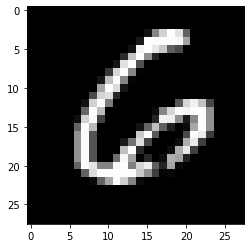

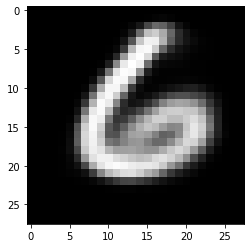

In [34]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    
    for X, Y in mymnist.test_data_loader:
        r = random.randint(0,len(mymnist.test_data_loader))
        X = X[0].view([-1, 28*28]).to(device)

        z_mean, z_log_sigma_sq, eps, z = encoder(X)
        X_hat = decoder(z)
        
        
        plt.imshow(X.cpu().reshape(28,28), cmap = 'gray')
        plt.show()
        
        plt.imshow(X_hat.cpu().reshape(28,28), cmap = 'gray')
        plt.show()
        break
        

In [35]:
display_num = 30

for X, Y in mymnist.test_data_loader:
    X = X.view([-1, 28*28]).to(device)
    break
    
z_mean, z_log_sigma_sq, eps, z = encoder(X)
X_hat = decoder(z)

In [36]:
display_num = 30
col = 28
row = 28

In [37]:
X[0].shape

torch.Size([784])

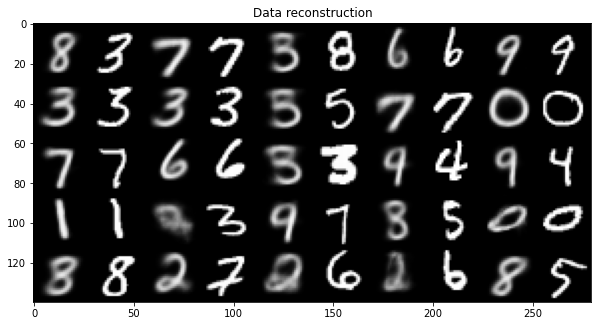

In [38]:
n = np.sqrt(display_num).astype(np.int32)
reconstructed = np.empty((col*n, 2*row*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (X_hat[i*n+j, :].cpu().detach().numpy().reshape(col, row), 
             X[i*n+j, :].cpu().reshape(col, row)),
            axis=1
        )
        reconstructed[i*col:(i+1)*col, j*2*row:(j+1)*2*row] = x

plt.figure(figsize=(10, 20))
plt.title('Data reconstruction')
plt.imshow(reconstructed, cmap='gray')
plt.show()

In [39]:
z_mnist = MyMNIST(5000)

In [40]:
for X, Y in z_mnist.test_data_loader:
    inputs = X.view([-1, 28*28]).to(device)
    Y = Y
    break

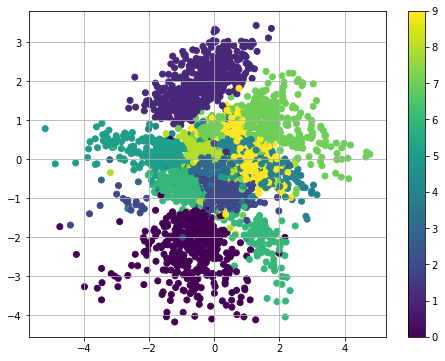

In [41]:

_, _, _, z = encoder(inputs)

z = z.detach().cpu().numpy()
plt.figure(figsize=(8, 6)) 
plt.scatter(z[:, 0], z[:, 1], c=Y)
plt.colorbar()
plt.grid()

In [42]:
n = 25
x_max = np.max(z[:,0])
x_min = np.min(z[:,0])

y_max = np.max(z[:, 1])
y_min = np.min(z[:, 1])

x = np.linspace(x_min, x_max, n)
y = np.linspace(y_min, y_max, n)

z_generated = np.empty((28*n, 28*n))

In [43]:
z

array([[-2.940042  , -0.676004  ],
       [-0.08404284, -0.29524517],
       [-1.717292  , -0.74196136],
       ...,
       [-0.44686618,  1.976741  ],
       [ 0.90341514, -0.18006451],
       [ 1.4540234 , -0.1205816 ]], dtype=float32)

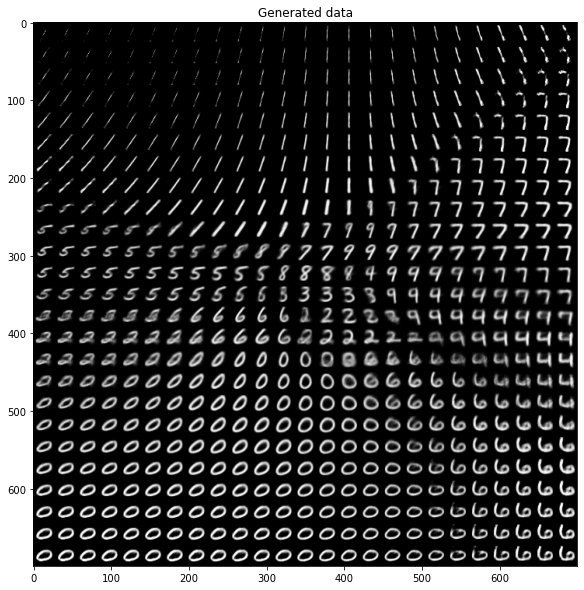

In [44]:
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([xi,yi])
        z = torch.tensor(z).float().view(1,num_z).to(device)
        X_hat = decoder(z)
        
        z_generated[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = X_hat[0].cpu().detach().numpy().reshape(28, 28)

plt.figure(figsize=(10, 10))        
plt.title('Generated data')
plt.imshow(z_generated, cmap="gray")
plt.show()